In [372]:
import cv2
import numpy as np
import os
from xml.dom.minidom import parse
from tqdm import tqdm
import glob
import pandas as pd

from skimage.filters import gabor_kernel
from scipy import ndimage as ndi
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.utils import resample

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

from tensorflow.keras.models import Model
from keras.utils.np_utils import to_categorical   
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from matplotlib import pyplot as plt
%matplotlib inline

## Face Mask Recognition by Classification

> 1- Detect faces by convetional way HAAR Cascade or DNN <br>
> 2- Classify by by conventional Gabor Filter & SVM or Fine-tuned VGG-19

## Dataset Reading & Feature Extraction

In [2]:
dataset_path = "../dataset/"
pretrained_models_path = "../pretrained_models/"
csv_path = os.path.join(dataset_path,"annotations")
images_path = os.path.join(dataset_path,"images")

csv_files = glob.glob(os.path.join(csv_path,"*.xml"))
images_files = glob.glob(os.path.join(images_path,"*.png"))

In [3]:
print("# of csv: {} \n# of images: {}".format(len(csv_files), len(images_files)))

# of csv: 853 
# of images: 853


In [4]:
"""
    label_mapping strategy;
        . without_mask - 0
        . with_mask - 1
        . mask_weared_incorrect - 2
"""

label_mapping = {
          "without_mask": 0,
          "with_mask": 1,
          "mask_weared_incorrect": 2
            }

In [5]:
def readFaceMaskDataset(csv_path):
    
    full_image = [] # for face detection purposes not for mask recognition
    wo_mask_image = []
    w_mask_image = []
    mwi_mask_image = []
    
    """
     Just remember;
            . without_mask - 0
            . with_mask - 1
            . mask_weared_incorrect - 2
    """

    dom = parse(csv_path)
    root = dom.documentElement
    img_name = root.getElementsByTagName("filename")[0].childNodes[0].data
    img_size = root.getElementsByTagName("size")[0]
    objects = root.getElementsByTagName("object")
    img_w = img_size.getElementsByTagName("width")[0].childNodes[0].data
    img_h = img_size.getElementsByTagName("height")[0].childNodes[0].data
    img_c = img_size.getElementsByTagName("depth")[0].childNodes[0].data
    
    # read image w.r.t.image_name which has written in xml file
    # pay attention! opencv reads image in BGR order, not RGB order.
    im = cv2.imread(os.path.join(images_path, img_name), cv2.COLOR_BGR2RGB)
    
    full_image.append(im)
    
    for box in objects:
        cls_name = box.getElementsByTagName("name")[0].childNodes[0].data
        x1 = int(box.getElementsByTagName("xmin")[0].childNodes[0].data)
        y1 = int(box.getElementsByTagName("ymin")[0].childNodes[0].data)
        x2 = int(box.getElementsByTagName("xmax")[0].childNodes[0].data)
        y2 = int(box.getElementsByTagName("ymax")[0].childNodes[0].data)
        
        # crop only mask related part from image
        cropped_im = im[y1:y2,x1:x2]
        
        if label_mapping[cls_name] == 0:
            wo_mask_image.append(cropped_im)
            
        if label_mapping[cls_name] == 1:
            w_mask_image.append(cropped_im)
        
        if label_mapping[cls_name] == 2:
            mwi_mask_image.append(cropped_im)
        else:
            pass
            
        
    return [full_image,wo_mask_image, w_mask_image, mwi_mask_image]

In [6]:
df_full = []
df_wo = []
df_w = []
df_mwi = []

i = 0
for csv_file in csv_files:
    f_im, wo_im, w_im, mwi_im = readFaceMaskDataset(csv_file)
    
    df_full += f_im
    df_wo += wo_im
    df_w += w_im
    df_mwi += mwi_im

In [7]:
print("Without Mask: {}\nWith Mask: {}\nMasked Weared Incorretly: {}".format(len(df_wo),len(df_w),len(df_mwi)))

Without Mask: 717
With Mask: 3232
Masked Weared Incorretly: 123


Visualization purposes; wo_mask, w_mask, incorretly worn


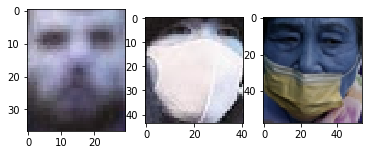

In [8]:
f, axarr = plt.subplots(1,3)
axarr[0].imshow(df_wo[0]);
axarr[1].imshow(df_w[0]);
axarr[2].imshow(df_mwi[0]);
print("Visualization purposes; wo_mask, w_mask, incorretly worn")

## Gabor Feature Extraction

In [301]:
# build gabor filters
# prepare filter bank kernels
kernels = []
for theta in range(4):
    theta = theta / 4. * np.pi
    for sigma in (1,2, 3):
        for frequency in (0.05, 0.25):
            kernel = np.real(gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)

In [302]:
def feature_extraction_Gabor(image, kernels):
    
    feats = np.zeros((len(kernels), 1), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(image, kernel, mode='wrap')
        feats[k] = filtered.mean()

    return feats

In [303]:
df_wo_gabor = []
df_w_gabor = []
df_mwi_gabor = []

# gabor feature extraction for df_wo
for im in df_wo:
    im = cv2.resize(im, (32,32), cv2.INTER_CUBIC)
    im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    feature = feature_extraction_Gabor(im,kernels)
    
    df_wo_gabor.append(feature)

# gabor feature extraction for df_w
for im in df_w:
    im = cv2.resize(im, (32,32), cv2.INTER_CUBIC)
    im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    feature = feature_extraction_Gabor(im,kernels)
    
    df_w_gabor.append(feature)
    
# gabor feature extraction for df_w
for im in df_mwi:
    im = cv2.resize(im, (32,32), cv2.INTER_CUBIC)
    im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    feature = feature_extraction_Gabor(im,kernels)
    
    df_mwi_gabor.append(feature)

1
2
3


In [304]:
# concat features w.r.t. labels to make train-test split
X = np.array(df_wo_gabor + df_w_gabor + df_mwi_gabor)
y = np.hstack((np.zeros(len(df_wo_gabor)), np.ones(len(df_w_gabor)), np.ones(len(df_mwi_gabor)) *2)).ravel()

In [305]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42, stratify=y)

In [306]:
print("Training Stage\n")
print("# wo_mask: {}\n# w_mask: {}\nmwi_mask: {}".format(len(np.where(y_train==0)[0]),len(np.where(y_train==1)[0]),len(np.where(y_train==2)[0])))
print("\n------\n")
print("Testing Stage\n")
print("# wo_mask: {}\n# w_mask: {}\nmwi_mask: {}".format(len(np.where(y_test==0)[0]),len(np.where(y_test==1)[0]),len(np.where(y_test==2)[0])))

Training Stage

# wo_mask: 645
# w_mask: 2908
mwi_mask: 111

------

Testing Stage

# wo_mask: 72
# w_mask: 324
mwi_mask: 12


In [307]:
# feature preprocessing
scaler = MinMaxScaler()

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1])

X_train = scaler.fit(X_train).transform(X_train)
X_test = scaler.fit(X_test).transform(X_test)

In [308]:
clf = SVC(kernel="linear").fit(X_train,y_train)
predictions = clf.predict(X_test)

In [309]:
print(classification_report(y_test, predictions, target_names=["wo_mask", "w_mask", "mwi_mask"]))
print("----")
print(confusion_matrix(y_test, predictions))
print("----")
print("Macro F1-Score: {:.5f}".format(f1_score(y_test, predictions, average="macro")))

              precision    recall  f1-score   support

     wo_mask       0.00      0.00      0.00        72
      w_mask       0.79      1.00      0.89       324
    mwi_mask       0.00      0.00      0.00        12

    accuracy                           0.79       408
   macro avg       0.26      0.33      0.30       408
weighted avg       0.63      0.79      0.70       408

----
[[  0  72   0]
 [  0 324   0]
 [  0  12   0]]
----
Macro F1-Score: 0.29508


C:\Users\PC\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\PC\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [310]:
## Penalization is applied to SVC to overcome the over-fitting problem a little bit 

In [311]:
clf_penalized = SVC(kernel="linear", class_weight='balanced',probability=True).fit(X_train,y_train)
predictions_penalized = clf_penalized.predict(X_test)

In [312]:
print(classification_report(y_test, predictions_penalized, target_names=["wo_mask", "w_mask", "mwi_mask"]))
print("----")
print(confusion_matrix(y_test, predictions_penalized))
print("----")
print("Macro F1-Score: {:.5f}".format(f1_score(y_test, predictions_penalized, average="macro")))

              precision    recall  f1-score   support

     wo_mask       0.30      0.58      0.39        72
      w_mask       0.87      0.47      0.61       324
    mwi_mask       0.07      0.50      0.12        12

    accuracy                           0.49       408
   macro avg       0.41      0.52      0.37       408
weighted avg       0.74      0.49      0.56       408

----
[[ 42  18  12]
 [ 99 153  72]
 [  1   5   6]]
----
Macro F1-Score: 0.37406


In [313]:
## Under sampling is applied onto training set w.r.t. labels to overcome the over-fitting problem

In [314]:
tr_df_wo_mask = X_train[y_train == 0]
tr_df_w_mask = X_train[y_train == 1]
tr_df_mwi_mask = X_train[y_train == 2]

n_tr_df_wo_mask = tr_df_wo_mask.shape[0]
n_tr_df_w_mask = tr_df_w_mask.shape[0]
n_tr_df_mwi_mask = tr_df_mwi_mask.shape[0]

print(n_tr_df_wo_mask, n_tr_df_w_mask, n_tr_df_mwi_mask)

# we'll down-sample the majority class which name is weared correctly.
# number of sample will be equal to the number of sample of without mask
tr_df_w_mask_downsampled = resample(tr_df_w_mask, replace=False, n_samples=n_tr_df_wo_mask, random_state=42)

n_tr_df_w_mask_downsampled = tr_df_w_mask_downsampled.shape[0]

print(n_tr_df_wo_mask, n_tr_df_w_mask_downsampled, n_tr_df_mwi_mask)

# concat arrays to feed linear classifier
X_train_downsampling = np.vstack((tr_df_wo_mask, tr_df_w_mask_downsampled, tr_df_mwi_mask))
y_train_sampling = np.hstack((np.zeros(len(tr_df_wo_mask)), np.ones(len(tr_df_w_mask_downsampled)), np.ones(len(tr_df_mwi_mask)) *2)).ravel()

645 2908 111
645 645 111


In [336]:
clf = SVC(kernel="linear",class_weight='balanced',probability=True).fit(X_train_downsampling,y_train_sampling)
predictions = clf.predict(X_test)

In [337]:
print(classification_report(y_test, predictions, target_names=["wo_mask", "w_mask", "mwi_mask"]))
print("----")
print(confusion_matrix(y_test, predictions))
print("----")
print("Macro F1-Score: {:.5f}".format(f1_score(y_test, predictions, average="macro")))

              precision    recall  f1-score   support

     wo_mask       0.27      0.49      0.34        72
      w_mask       0.85      0.47      0.61       324
    mwi_mask       0.06      0.50      0.11        12

    accuracy                           0.48       408
   macro avg       0.39      0.49      0.35       408
weighted avg       0.72      0.48      0.55       408

----
[[ 35  23  14]
 [ 94 153  77]
 [  2   4   6]]
----
Macro F1-Score: 0.35402


In [329]:
## Macro f1-score is up from 0.29 to 0.38 without penalization

In [330]:
# Then make upsampling on mask_weared_incorrectly, after downsampling has done on with_mask class.

In [344]:
tr_df_wo_mask = X_train[y_train == 0]
tr_df_w_mask = X_train[y_train == 1]
tr_df_mwi_mask = X_train[y_train == 2]

n_tr_df_wo_mask = tr_df_wo_mask.shape[0]
n_tr_df_w_mask = tr_df_w_mask.shape[0]
n_tr_df_mwi_mask = tr_df_mwi_mask.shape[0]

print(n_tr_df_wo_mask, n_tr_df_w_mask, n_tr_df_mwi_mask)

# we'll down-sample the majority class which name is weared correctly.
# then we'll up-sample the minority class which name is mask worn incorretly
# number of sample will be equal to the number of sample of without mask
tr_df_wo_mask_downsampled = resample(tr_df_wo_mask, replace=False, n_samples=n_tr_df_mwi_mask * 2, random_state=42)
tr_df_w_mask_downsampled = resample(tr_df_w_mask, replace=False, n_samples=n_tr_df_mwi_mask * 2, random_state=42)
tr_df_mwi_mask_upsampled = resample(tr_df_mwi_mask, replace=True, n_samples=n_tr_df_mwi_mask * 2, random_state=42)

n_tr_df_wo_mask_downsampled = tr_df_wo_mask_downsampled.shape[0]
n_tr_df_w_mask_downsampled = tr_df_w_mask_downsampled.shape[0]
n_tr_df_mwi_mask_upsampled = tr_df_mwi_mask_upsampled.shape[0]

print(n_tr_df_wo_mask_downsampled, n_tr_df_w_mask_downsampled, n_tr_df_mwi_mask_upsampled)

# concat arrays to feed linear classifier
X_train_downsampled_upsampled = np.vstack((tr_df_wo_mask_downsampled, tr_df_w_mask_downsampled, tr_df_mwi_mask_upsampled))
y_train_downsampled_upsampled = np.hstack((np.zeros(len(tr_df_wo_mask_downsampled)), np.ones(len(tr_df_w_mask_downsampled)), np.ones(len(tr_df_mwi_mask_upsampled)) *2)).ravel()

645 2908 111
222 222 222


In [345]:
clf = SVC(kernel="linear", class_weight='balanced',probability=True).fit(X_train_downsampled_upsampled,y_train_downsampled_upsampled)
predictions = clf.predict(X_test)

In [346]:
print(classification_report(y_test, predictions, target_names=["wo_mask", "w_mask", "mwi_mask"]))
print("----")
print(confusion_matrix(y_test, predictions))
print("----")
print("Macro F1-Score: {:.5f}".format(f1_score(y_test, predictions, average="macro")))

              precision    recall  f1-score   support

     wo_mask       0.29      0.49      0.36        72
      w_mask       0.86      0.53      0.66       324
    mwi_mask       0.07      0.50      0.12        12

    accuracy                           0.52       408
   macro avg       0.41      0.51      0.38       408
weighted avg       0.74      0.52      0.59       408

----
[[ 35  23  14]
 [ 85 173  66]
 [  2   4   6]]
----
Macro F1-Score: 0.38119


## ResNet-50 ,CNN, Recognition Based Model by Transfer Learning


We already have raw dataset which consists of; w/o mask, w mask, mask_worn_incorretly in RGB format in following lists;<br>
       . df_wo <br>
       . df_w <br>
       . df_mwi <br>

In [327]:
# Resize the images then prepare <data,label> pair
image_size = (64,64)
raw_images = []
raw_labels = []

for im in df_wo:
    # resize then preprocess - this preprocessing is specialized to resnet-50 on imagenet dataset-
    im = preprocess_input(cv2.resize(im, (64,64), cv2.INTER_CUBIC))
    raw_images.append(im)
# append 0 as the number of df_wo
raw_labels += [0] * len(df_wo)

for im in df_w:
    # resize then preprocess - this preprocessing is specialized to resnet-50 on imagenet dataset-
    im = preprocess_input(cv2.resize(im, (64,64), cv2.INTER_CUBIC))
    raw_images.append(im)
# append 0 as the number of df_w
raw_labels += [1] * len(df_w)

for im in df_mwi:
    # resize then preprocess - this preprocessing is specialized to resnet-50 on imagenet dataset-
    im = preprocess_input(cv2.resize(im, (64,64), cv2.INTER_CUBIC))
    raw_images.append(im)
# append 2 as the number of df_mwi
raw_labels += [2] * len(df_mwi)

In [328]:
# make integer number label data to one-hot encoding type
categorical_labels = to_categorical(raw_labels, num_classes=3)

In [329]:
# train_test split
X_train, X_test, y_train, y_test = train_test_split(np.array(raw_images), np.array(categorical_labels), test_size=0.10, random_state=42,
                                                    stratify=categorical_labels)

In [544]:
# resnet model preparation

resnet_base_model = ResNet50(weights='imagenet', include_top=False)
resnet_base_model.trainable =False
# add a global spatial average pooling layer
x = resnet_base_model.output
x = layers.GlobalMaxPool2D()(x)
# let's add a fully-connected layer
x = layers.Dense(128, activation='relu')(x)
# and a logistic layer -- let's say we have 3 classes
predictions = layers.Dense(3, activation='softmax')(x)

# this is the model we will train and specialized to the our problem
model = Model(inputs=resnet_base_model.input, outputs=predictions)

In [545]:
model.summary()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_23[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [546]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

In [547]:
# define callback to save best_model only
best_model_saver = keras.callbacks.ModelCheckpoint(os.path.join(dataset_path,"best_model.h5"), save_best_only=True,
                                                   monitor="val_accuracy", mode='max', verbose=1)

In [548]:
model.fit(X_train, y_train, batch_size=4, epochs=50,validation_split=0.05, callbacks=[best_model_saver], 
          shuffle=True,verbose=1)

Train on 3480 samples, validate on 184 samples
Epoch 1/50
3472/3480 [============================>.] - ETA: 0s - loss: 0.5312 - accuracy: 0.8358
Epoch 00001: val_accuracy improved from -inf to 0.82609, saving model to ../dataset/best_model.h5
3480/3480 [==============================] - 14s 4ms/sample - loss: 0.5301 - accuracy: 0.8362 - val_loss: 0.6669 - val_accuracy: 0.8261
Epoch 2/50
3460/3480 [============================>.] - ETA: 0s - loss: 0.3886 - accuracy: 0.8636
Epoch 00002: val_accuracy improved from 0.82609 to 0.87500, saving model to ../dataset/best_model.h5
3480/3480 [==============================] - 11s 3ms/sample - loss: 0.3886 - accuracy: 0.8638 - val_loss: 0.4571 - val_accuracy: 0.8750
Epoch 3/50
3460/3480 [============================>.] - ETA: 0s - loss: 0.3635 - accuracy: 0.8699
Epoch 00003: val_accuracy improved from 0.87500 to 0.88587, saving model to ../dataset/best_model.h5
3480/3480 [==============================] - 11s 3ms/sample - loss: 0.3655 - accuracy: 

3464/3480 [============================>.] - ETA: 0s - loss: 0.2542 - accuracy: 0.9042
Epoch 00028: val_accuracy did not improve from 0.91304
3480/3480 [==============================] - 11s 3ms/sample - loss: 0.2553 - accuracy: 0.9037 - val_loss: 0.4148 - val_accuracy: 0.9022
Epoch 29/50
3476/3480 [============================>.] - ETA: 0s - loss: 0.2593 - accuracy: 0.9019
Epoch 00029: val_accuracy did not improve from 0.91304
3480/3480 [==============================] - 11s 3ms/sample - loss: 0.2591 - accuracy: 0.9020 - val_loss: 0.3904 - val_accuracy: 0.8967
Epoch 30/50
3472/3480 [============================>.] - ETA: 0s - loss: 0.2567 - accuracy: 0.9041
Epoch 00030: val_accuracy did not improve from 0.91304
3480/3480 [==============================] - 11s 3ms/sample - loss: 0.2573 - accuracy: 0.9040 - val_loss: 0.3699 - val_accuracy: 0.9130
Epoch 31/50
3476/3480 [============================>.] - ETA: 0s - loss: 0.2842 - accuracy: 0.8930
Epoch 00031: val_accuracy did not improve f

In [639]:
# load the best model then predict
best_resnet_transfer_learned_model = keras.models.load_model(os.path.join(dataset_path,"best_model.h5"))

predictions = best_resnet_transfer_learned_model.predict(X_test)

In [640]:
# conventional arg-max over softmax and y_Test labels
predictions = np.argmax(predictions, axis=1)
gt_labels = np.argmax(y_test, axis=1)

In [644]:
print("We have obtained ~ 0.72 macro f1-score without doing any augmentation")

We have obtained ~ 0.72 macro f1-score without doing any augmentation


In [643]:
print(classification_report(gt_labels, predictions, target_names=["wo_mask", "w_mask", "mwi_mask"]))
print("----")
print(confusion_matrix(gt_labels, predictions))
print("----")
print("Macro F1-Score: {:.5f}".format(f1_score(gt_labels, predictions, average="macro")))

              precision    recall  f1-score   support

     wo_mask       0.78      0.81      0.79        72
      w_mask       0.95      0.93      0.94       324
    mwi_mask       0.38      0.50      0.43        12

    accuracy                           0.90       408
   macro avg       0.70      0.75      0.72       408
weighted avg       0.90      0.90      0.90       408

----
[[ 58  12   2]
 [ 14 302   8]
 [  2   4   6]]
----
Macro F1-Score: 0.72130


## Face Detection

> 1- Detection using conventional Haar Cascade <br>
> 2- Detection using DNN

In [646]:
## Haar Cascade based face detection; cascaded algorithms which uses multiple weak filters to build a strong face detector

In [661]:
face_cascade = cv2.CascadeClassifier(os.path.join(pretrained_models_path, 'haarcascade_frontalface_default.xml'))

In [688]:
counter = 0
for img in df_full:
    # deep copy of img
    img_rect = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Detect the faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.01)
    # Draw the rectangle around each face
    for (x, y, w, h) in faces:
        cv2.rectangle(img_rect, (x, y), (x+w, y+h), (255, 0, 0), 2)
        
    cv2.imwrite(os.path.join(dataset_path,"haarcascade_face_result/")+str(counter)+".png",img_rect)
    
    counter += 1

In [692]:
## DNN Based Face Recognition, the model is based on SSD network architecture
## The model uses VGG to feature extraction then expects 300,300,3 as an input

In [697]:
ssd_detector = cv2.dnn.readNetFromCaffe(os.path.join(pretrained_models_path,"deploy.prototxt" ), os.path.join(pretrained_models_path,"res10_300x300_ssd_iter_140000.caffemodel" ))
ssd_labels = ["img_id", "is_face", "confidence", "left", "top", "right", "bottom"]

In [701]:
counter = 0
for img in df_full:
    # deep copy of img
    base_img = img.copy()
    
    # initial size of a given image
    original_size = img.shape
    # target size - ssd acceptance for input
    target_size = (300, 300)
    
    img_resized = cv2.resize(img, target_size, cv2.INTER_CUBIC)
    
    aspect_ratio_x = (original_size[1] / target_size[1])
    aspect_ratio_y = (original_size[0] / target_size[0])
    
    imageBlob = cv2.dnn.blobFromImage(image = img_resized)
    
    ssd_detector.setInput(imageBlob)
    detections = ssd_detector.forward()

    detections_df = pd.DataFrame(detections[0][0], columns = ssd_labels)

    detections_df = detections_df[detections_df['is_face'] == 1] #0: background, 1: face
    detections_df = detections_df[detections_df['confidence'] >= 0.20]

    detections_df['left'] = (detections_df['left'] * 300).astype(int)
    detections_df['bottom'] = (detections_df['bottom'] * 300).astype(int)
    detections_df['right'] = (detections_df['right'] * 300).astype(int)
    detections_df['top'] = (detections_df['top'] * 300).astype(int)

    for i, instance in detections_df.iterrows():
        
        confidence_score = str(round(100*instance["confidence"], 2))+" %"
        left = instance["left"]
        right = instance["right"]
        bottom = instance["bottom"]
        top = instance["top"]
        
        detected_face = base_img[int(top*aspect_ratio_y):int(bottom*aspect_ratio_y), int(left*aspect_ratio_x):int(right*aspect_ratio_x)]
        if detected_face.shape[0] > 0 and detected_face.shape[1] > 0:
            cv2.rectangle(base_img, (int(left*aspect_ratio_x), int(top*aspect_ratio_y)), (int(right*aspect_ratio_x), int(bottom*aspect_ratio_y)),  (255, 0, 0), 2) 
    
    cv2.imwrite(os.path.join(dataset_path,"cnn_face_result/")+str(counter)+".png",base_img)
    
    counter += 1

Visualization purposes; Left: HAAR cascade detection result, Right: SSD detection result


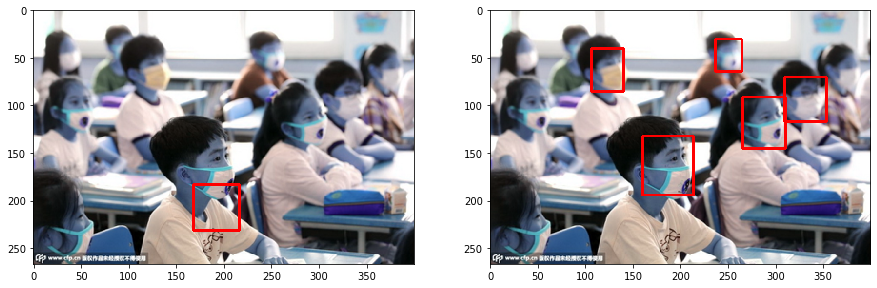

In [708]:
sample_idx_ = 8

haar_example_ = cv2.imread(os.path.join(dataset_path,"haarcascade_face_result/")+str(sample_idx_)+".png")
ssd_example_ = cv2.imread(os.path.join(dataset_path,"cnn_face_result/")+str(sample_idx_)+".png")
f, axarr = plt.subplots(1,2,figsize=(15,15))
axarr[0].imshow(haar_example_);
axarr[1].imshow(ssd_example_);

print("Visualization purposes; Left: HAAR cascade detection result, Right: SSD detection result")